In [1]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
import jax.random as jr
import pandas as pd

from uncprop.utils.experiment import Experiment
from uncprop.models.elliptic_pde.experiment import PDEReplicate

base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
key = jr.key(7932523)
key, key_experiment = jr.split(key)

experiment_name = 'pde_experiment'
experiment_settings = {
    'name': experiment_name,
    'base_out_dir': base_dir / 'out' / experiment_name,
    'num_reps': 1,
    'base_key': key_experiment,
    'Replicate': PDEReplicate,
    'write_to_file': True,
}

noise_sd = 1e-3
obs_locations = jnp.array([10, 30, 60, 75])
setup_kwargs = {
    'n_design': 12,
    'obs_locations': obs_locations,
    'noise_cov': noise_sd**2 * jnp.identity(len(obs_locations)),
}

def make_subdir_name(setup_kwargs, run_kwargs):
    n = setup_kwargs['n_design']
    return f'n_design_{n}'

run_kwargs = {
    'n_warmup': 50_000
}

pde_experiment = Experiment(subdir_name_fn=make_subdir_name, 
                            **experiment_settings)



Creating new output directory: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/pde_experiment


In [3]:
results, failed_reps = pde_experiment(setup_kwargs=setup_kwargs, run_kwargs=run_kwargs)

Creating experiment sub-directory: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/pde_experiment/n_design_12
Running replicate 0
	Fitting surrogate
	Running samplers
No save_results() methods implemented.
0 of 1 replicates failed.


In [4]:
rep = results[0]
posterior = rep.posterior

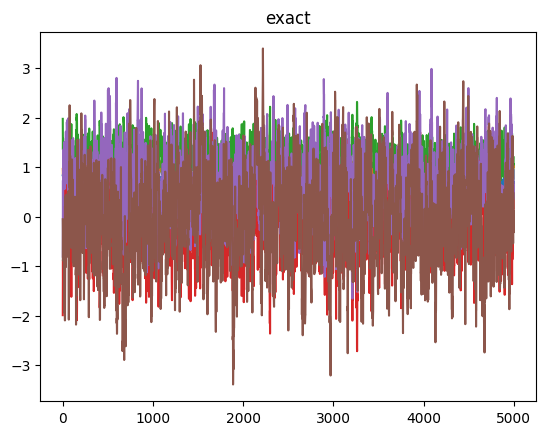

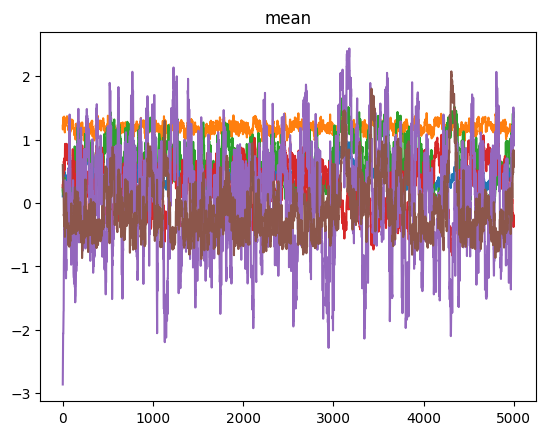

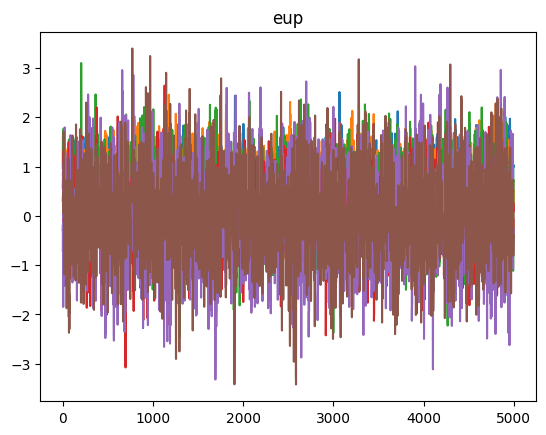

In [5]:
for mcmc_tag in ['exact', 'mean', 'eup']:
    samp = rep.samples[mcmc_tag]
    for i in range(posterior.dim):
        plt.plot(samp[:,i])
        plt.title(mcmc_tag)
    plt.show()

In [ ]:
key_prior_samp, key = jr.split(key)

samples = rep.samples
samples['prior'] = posterior.prior.sample(key_prior_samp, n=samples['exact'].shape[0])

In [ ]:
key_subsamp, key = jr.split(key)

dist1_name = 'exact'
dist2_name = 'eup'

dist_names = ['prior', 'eup', 'mean', 'exact']

df_list = []
for name in dist_names:
    df = pd.DataFrame(samples[name], columns=posterior.prior.par_names)
    df['dist'] = name
    df_list.append(df)
samp_df = pd.concat(df_list, ignore_index=True)

# idx = jr.choice(key_subsamp, samp.shape[0], (10_000,))
# post_samp_df = pd.DataFrame(samp[idx], columns=posterior.prior.par_names)

sns.pairplot(samp_df, hue='dist', diag_kind='kde')

In [ ]:
postsamp = samp[-50:,:]
param, log_field, pde_solution, observable = posterior.likelihood.forward_model.forward_with_intermediates(postsamp)
xgrid = posterior.likelihood.forward_model.pde_settings.xgrid

plt.plot(xgrid, pde_solution.T, color='gray')
plt.show()


### Test RFF approximation

In [ ]:
def check_rff_approx(key, posterior, surrogate, trajectories, n_test=500):
    inputs = posterior.prior.sample(key, n_test)

    pred = surrogate(inputs)
    pred_rff = trajectories(inputs)
    m = pred.mean
    sd = pred.stdev
    m_rff = jnp.mean(pred_rff, axis=0)
    sd_rff = jnp.std(pred_rff, axis=0)

    for i in range(surrogate.output_dim):
        fig, axs = plt.subplots(1, 2)
        axs = axs.ravel()
        axs[0].scatter(m[i], m_rff[i])
        axs[0].set_title('mean')
        xmin, xmax = axs[0].get_xlim()
        ymin, ymax = axs[0].get_ylim()
        grid = jnp.linspace(xmin, xmax, 100)
        axs[0].plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')

        axs[1].scatter(sd[i], sd_rff[i])
        axs[1].set_title('sd')
        xmin, xmax = axs[1].get_xlim()
        ymin, ymax = axs[1].get_ylim()
        grid = jnp.linspace(xmin, xmax, 100)
        axs[1].plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')

        fig.tight_layout()
        fig.show()

In [ ]:
from uncprop.models.elliptic_pde.surrogate import (
    _build_batch_basis_funcs,
    _build_batch_basis_noise_dist,
    sample_approx_trajectory,
)

num_rff = 1000
num_trajectories = 10_000

# create batch of trajectories
surrogate = rep.posterior_surrogate.surrogate
batchgp = rep.batchgp

key, key_noise, key_rff, key_plot = jr.split(key, 4)
noise_dist = _build_batch_basis_noise_dist(surrogate, batchgp, num_rff)
noise_realization = noise_dist.sample(key_noise, num_trajectories)
basis_fn = _build_batch_basis_funcs(key_rff, surrogate, batchgp, num_rff)
trajectories = sample_approx_trajectory(basis_fn, noise_realization, surrogate, num_rff)

In [ ]:
check_rff_approx(key_plot, posterior, surrogate, trajectories, n_test=500)

### Testing vectorization over chains

In [ ]:
from uncprop.utils.distribution import _sample_gaussian_tril
import blackjax

n_chains = 2

key, key_init_pos, key_mcmc = jr.split(key, 3)
key_init_states = jr.split(key, n_chains)
key_steps = jr.split(key, n_chains)

prop_cov = 0.5 * jnp.cov(rep.samples['exact'], rowvar=False)
L = jnp.linalg.cholesky(prop_cov, upper=False)
initial_positions = posterior.prior.sample(key_init_pos, n_chains)

logdensity = lambda x: posterior.log_density(x).squeeze()
def proposal(key, position):
    return _sample_gaussian_tril(key, m=position, L=L).squeeze()

rmh = blackjax.rmh(logdensity, proposal)
initial_states = jax.vmap(rmh.init)(initial_positions, key_init_states)

In [ ]:
states = mcmc_loop_multiple_chains(key=key_mcmc, 
                                   kernel=rmh.step,
                                   initial_states=initial_states,
                                   num_samples=10_000,
                                   num_chains=n_chains)

In [ ]:
for i in range(n_chains):
    for j in range(posterior.dim):
        plt.plot(states.position[:,i,j])
    plt.show()

### Test

In [ ]:
from uncprop.models.elliptic_pde.experiment import PDEReplicate

key = jr.key(4635435)
key_init, key_run, key_surrogate = jr.split(key, 3)

rep = PDEReplicate(key_init, n_design=8)
rep(key_run, write_to_file=False)
posterior = rep.posterior
forward_model = posterior.likelihood.forward_model
logdensity = lambda x: posterior.log_density(x).squeeze()

In [ ]:
for i in range(6):
    plt.plot(rep.samples['exact'])
plt.show()

In [ ]:
import jax
from uncprop.core.samplers import (
    init_rwmh_kernel, 
    _init_dist_proposal_cov, 
    mcmc_loop_multiple_chains,
    init_adaptive_rwmh_kernel,
    AdaptationSettings,
)

key = jr.key(3254232)

In [ ]:
key, key_init_pos = jr.split(key, 2)

n_chains = 2
initial_positions = posterior.prior.sample(key_init_pos, n_chains)

initial_state, kernel = init_adaptive_rwmh_kernel(key=key,
                                                  logdensity_fn=logdensity,
                                                  initial_position=initial_positions,
                                                  adapt_settings=AdaptationSettings(),
                                                  initial_cov=jnp.eye(posterior.dim),
                                                  n_chains=n_chains)

In [ ]:
jnp.broadcast_to(jnp.asarray(jnp.array([5, 6]))[..., None, None], (2, 3, 3))

In [ ]:
x = jnp.ones((4, 5))

perm = jnp.arange(x.ndim, dtype=jnp.int64)
perm = perm.at[-2:].set(jnp.array([perm[-1], perm[-2]]))
jnp.transpose(x, perm).shape

In [ ]:
key, key_mcmc = jr.split(key)

states = mcmc_loop_multiple_chains(key=key_mcmc,
                                   kernel=kernel,
                                   initial_states=initial_state,
                                   num_samples=10_000,
                                   num_chains=n_chains)

In [ ]:
for i in range(n_chains):
    for j in range(posterior.dim):
        plt.plot(states.position[:,i,j])
    plt.show()

### TEMP

In [ ]:
from uncprop.models.elliptic_pde.inverse_problem import generate_pde_inv_prob_rep
from uncprop.core.samplers import (
    sample_distribution,
    init_custom_rwmh_kernel,
    mcmc_loop_multiple_chains,
)

key = jr.key(23423)

In [ ]:
key, key_inv_prob = jr.split(key)

posterior = generate_pde_inv_prob_rep(key_inv_prob, 
                                    n_kl_modes=6,
                                    obs_locations=jnp.array([10, 30, 60, 75]),
                                    noise_cov=1e-3**2 * jnp.identity(4))[0]

In [ ]:
key, key_samp, key_init_pos = jr.split(key, 3)
n_chains = 1

# TODO:
# - check that tuned covariances are correctly being passed to second stage
# - fix so that n_chains=1 case works

results = sample_distribution(key_samp,
                              dist=posterior, 
                              initial_position=posterior.prior.sample(key_init_pos, n_chains),
                              n_samples=10_000, 
                              n_warmup=50_000,
                              n_chains=n_chains)

In [ ]:
from uncprop.core.samplers import mcmc_loop, mcmc_loop_multiple_chains
import jax

In [ ]:
from uncprop.core.samplers import init_adaptive_rwmh_kernel, AdaptationSettings

In [ ]:
L = results['initial_state'].proposal_tril
C = L @ jnp.transpose(L, (0, 2, 1))

In [ ]:
initial_state, kernel = init_adaptive_rwmh_kernel(key=key,
                                                  initial_position=results['positions'][-1],
                                                  logdensity_fn=lambda x: posterior.log_density(x).squeeze(),
                                                  adapt_settings=AdaptationSettings(),
                                                  initial_cov=C,
                                                  initial_log_scale=jnp.zeros(n_chains),
                                                  n_chains=n_chains)

In [ ]:
test2 = mcmc_loop_multiple_chains(key=key,
                                  kernel=kernel,
                                  initial_state=initial_state,
                                  num_samples=50_000,
                                  num_chains=4)

tester = jax.block_until_ready(test2)

In [ ]:
test1 = mcmc_loop(key=key,
                  kernel=results['kernel'],
                  initial_state=jax.tree.map(lambda x: x[0], results['initial_state']),
                  num_samples=50_000)
tester = jax.block_until_ready(test1)

In [ ]:
test2 = mcmc_loop_multiple_chains(key=key,
                                  kernel=results['kernel'],
                                  initial_state=results['initial_state'],
                                  num_samples=50_000,
                                  num_chains=1)

tester = jax.block_until_ready(test2)

In [ ]:
# warmup
for i in range(n_chains):
    for j in range(posterior.dim):
        plt.plot(warmup_samp.position[:,i,j])
    plt.show()

In [ ]:
# final sampler
for i in range(n_chains):
    for j in range(posterior.dim):
        plt.plot(positions[:,i,j])
    plt.show()

In [ ]:
key_init_rwmh, key = jr.split(key, 2)
logdensity = lambda x: posterior.log_density(x).squeeze()

init_fn, kernel = init_custom_rwmh_kernel(key=key_init_rwmh,
                                          logdensity_fn=logdensity,
                                          initial_position=None, prop_cov=None)

In [ ]:
import jax

key_init_pos, key_mcmc, key = jr.split(key, 3)
n_chains = 2
d = posterior.dim

initial_position = posterior.prior.sample(key_init_pos, n_chains)
prop_cov = jnp.eye(posterior.dim)
prop_tril = jnp.linalg.cholesky(prop_cov, upper=False)

prop_tril = 0.002 * jnp.stack([prop_tril, 2*prop_tril])

# prop_tril = jnp.broadcast_to(prop_tril, (n_chains, d, d))

initial_state = jax.vmap(init_fn, in_axes=(0, 0))(initial_position, prop_tril)

In [ ]:
states = mcmc_loop_multiple_chains(key=key_mcmc, 
                                   kernel=kernel,
                                   initial_state=initial_state,
                                   num_samples=10_000,
                                   num_chains=n_chains)

In [ ]:
for i in range(n_chains):
    for j in range(posterior.dim):
        plt.plot(states.position[:,i,j])
    plt.show()